# Proyecto: Detector de Spam con IA

Bienvenidos al taller práctico. Vamos a construir una **Inteligencia Artificial** capaz de leer correos electrónicos y decidir si son **Spam** (correo basura) o **Ham** (correo legítimo) según su asunto.

### ¿Qué aprenderemos hoy?
1.  Cómo las computadoras entienden el texto (Vectorización).
2.  Cómo se ve una Red Neuronal por dentro (Capas y Neuronas).
3.  Cómo aprende la máquina de sus errores (Entrenamiento).


## 1. Los Datos 

Para que la IA aprenda, necesita ejemplos. Vamos a crear una lista de correos falsos pero realistas. Unos serán intentos de estafa (**etiqueta 1**) y otros mensajes normales de trabajo o familia (**etiqueta 0**).

In [7]:
import pandas as pd
import numpy as np

# DATOS DE ENTRENAMIENTO
data = {
    'texto': [
        # SPAM (1) - Ofertas, Dinero, Urgencia
        "Oferta exclusiva gana dinero rapido", "Urgente actualiza tus datos bancarios",
        "Felicitaciones ganaste un iPhone", "Prestamos sin intereses aplica ya",
        "Click aqui para tu premio", "Descuento del 90% solo hoy",
        "Eres el visitante un millon", "Compra ahora y paga despues",
        "Gana $5000 trabajando desde casa", "Tu cuenta ha sido bloqueada",
        "Pierde peso en 3 dias garantizado", "Aumenta tus seguidores en instagam",
        "Gana dinero rapido haciendo click aqui", "Casino online bono de bienvenida",
        "Herencia del principe nigeriano", "Recupera tu contraseña inmediatamente",
        "Has sido seleccionado para una oferta", "Liquidación total por cierre",
        "Gana un viaje a las Bahamas", "Trabaja menos y gana mas",
        "Factura vencida pagar ahora", "Alerta de seguridad en tu cuenta",
        "Regalo sorpresa abre el link", "Farmacia online sin receta",
        "Conoce solteros en tu area", "Invierte en crypto y hazte rico",
        
        # NO SPAM (0) - Trabajo, Familia, Normalidad
        "Reunion de equipo mañana a las 10", "Informe mensual de ventas adjunto",
        "Recordatorio almuerzo con cliente", "Agenda para la planificacion trimestral",
        "Minuta de la reunion de ayer", "Solicitud de vacaciones aprobada",
        "Cambio de contraseña requerido", "Fwd: Presupuesto 2024",
        "Invitacion a boda de Ana", "Confirmacion de cita medica",
        "Rutina de gimnasio nueva", "Comprobante de transferencia",
        "Receta de pastel de chocolate", "Horario de clases semestre 2",
        "Foto de las vacaciones", "Hola mamá llamame cuando puedas",
        "Resumen del proyecto Q3", "¿Vamos al cine el viernes?",
        "Lista de compras para la cena", "Confirmación de vuelo",
        "Borrador del contrato para revisión", "Feliz cumpleaños atrasado",
        "Ya llegue a la oficina", "Te envio los documentos escaneados",
        "Reserva confirmada hotel", "Factura de servicios basicos"
    ],
    'etiqueta': [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    ]
}

df = pd.DataFrame(data)

# Mezclamos los datos para que no estén ordenados (Spam primero, No Spam después)
df = df.sample(frac=1).reset_index(drop=True)

print(f"Total de correos: {len(df)}")
print(df.head())

Total de correos: 52
                                   texto  etiqueta
0           Factura de servicios basicos         0
1  Urgente actualiza tus datos bancarios         1
2           Comprobante de transferencia         0
3                 Foto de las vacaciones         0
4    Oferta exclusiva gana dinero rapido         1


## 2. Traducción: De Palabras a Números

Las redes neuronales no saben leer español. Solo entienden matemáticas. Usaremos **TF-IDF** (Term Frequency - Inverse Document Frequency). 

- Si una palabra aparece mucho en un correo pero poco en general (ej: "nigeriano"), es importante.
- Si una palabra aparece en todos lados (ej: "el"), no es importante.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch

# Configuración: Vamos a buscar las top 100 palabras más importantes
MAX_PALABRAS = 100

# 1. Entrenar el traductor (Vectorizer)
vectorizer = TfidfVectorizer(max_features=MAX_PALABRAS)
X = vectorizer.fit_transform(df['texto']).toarray()
y = df['etiqueta'].values

# 2. Convertir a formato PyTorch (Tensores)
# PyTorch usa 'float32' para decimales y 'long' para enteros (etiquetas)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# 3. Separar en dos grupos: Estudio (Train) y Examen (Test)
# Usamos el 80% para estudiar y guardamos el 20% para la prueba final.
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

print(f"Datos de Entrenamiento: {X_train.shape} (Filas, Palabras)")
print(f"Datos de Prueba: {X_test.shape}")

Datos de Entrenamiento: torch.Size([41, 100]) (Filas, Palabras)
Datos de Prueba: torch.Size([11, 100])


## 3. Construyendo el Modelo

Vamos a diseñar nuestra Red Neuronal. Será sencilla pero efectiva:

1.  **Entrada:** 100 neuronas (una por cada palabra posible).
2.  **Capa Oculta:** 20 neuronas (donde procesa la "intuición").
3.  **Salida:** 2 neuronas (Probabilidad de ser Spam vs. Ham).

In [9]:
import torch.nn as nn
import torch.optim as optim

class SpamDetector(nn.Module):
    def __init__(self):
        super().__init__()
        # Capa 1: Entra información -> Proceso interno
        self.capa_oculta = nn.Linear(MAX_PALABRAS, 20)
        self.activacion = nn.ReLU() # Esto permite aprender patrones no lineales
        
        # Capa 2: Proceso interno -> Decisión final
        self.capa_salida = nn.Linear(20, 2)
    
    def forward(self, x):
        # El camino de ida de la información
        x = self.capa_oculta(x)
        x = self.activacion(x)
        x = self.capa_salida(x)
        return x

# Inicializamos la IA
model = SpamDetector()

# Definimos cómo aprende
criterion = nn.CrossEntropyLoss() # Calcula qué tan mal se equivocó
optimizer = optim.Adam(model.parameters(), lr=0.01) # Calculo de parámetros 

## 4. El Entrenamiento

Haremos que la IA lea los correos de entrenamiento 100 veces (`epochs`). En cada vuelta:
1.  Intenta adivinar.
2.  Le decimos la respuesta correcta.
3.  Ajusta sus "neuronas" interna para mejorar.

In [10]:
epochs = 100 # Número de vueltas
historial_perdida = []

print("---- INICIANDO ENTRENAMIENTO ----")

for epoch in range(epochs):
    # 1. PREDICCIÓN (Forward pass)
    logits = model(X_train)
    
    # 2. EVALUACIÓN (Calcular error)
    loss = criterion(logits, y_train)
    historial_perdida.append(loss.item())
    
    # 3. APRENDIZAJE (Backward pass)
    optimizer.zero_grad() # Borrar memoria anterior
    loss.backward()       # Calcular ajustes necesarios
    optimizer.step()      # Aplicar ajustes
    
    # Reporte cada 20 épocas
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Error: {loss.item():.4f}")

print("---- ENTRENAMIENTO FINALIZADO ----")

---- INICIANDO ENTRENAMIENTO ----
Epoch   0 | Error: 0.6947
Epoch  20 | Error: 0.1826
Epoch  40 | Error: 0.0176
Epoch  60 | Error: 0.0058
Epoch  80 | Error: 0.0033
---- ENTRENAMIENTO FINALIZADO ----


## 5. Visualizar el Progreso
Veamos cómo disminuyó el error a lo largo del tiempo. Si la línea baja, ¡aprendió!

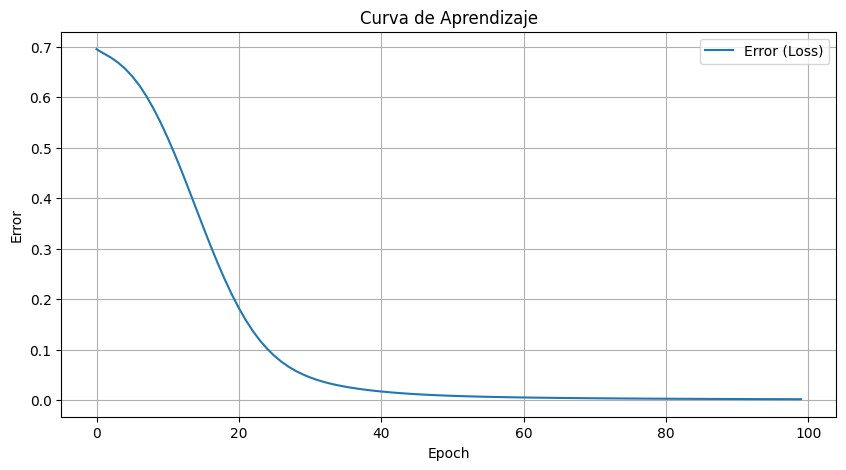

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(historial_perdida, label='Error (Loss)')
plt.title('Curva de Aprendizaje')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

## 6. Prueba del detector

Escribe un asunto y veamos si la IA puede detectar si es Spam o no.

In [12]:
def detector_spam(texto_usuario):

    # 1. Traducir texto a números 
    x_num = vectorizer.transform([texto_usuario]).toarray()
    x_tensor = torch.tensor(x_num, dtype=torch.float32)
    
    # 2. Usar la IA
    model.eval() 
    with torch.no_grad():
        prediccion_bruta = model(x_tensor)
        probabilidades = torch.softmax(prediccion_bruta, dim=1)
        
        # La clase con mayor probabilidad gana
        clase_ganadora = torch.argmax(probabilidades).item()
        confianza = probabilidades[0][clase_ganadora].item() * 100
    
    # 3. Mostrar resultado
    etiqueta = "SPAM DETECTADO" if clase_ganadora == 1 else "CORREO SEGURO"
    print(f"\nAnalizando: '{texto_usuario}'")
    print(f"Resultado: {etiqueta} (Confianza: {confianza:.1f}%)")

# ---- ZONA DE PRUEBAS ----
detector_spam("Gana dinero rapido haciendo click aqui")
detector_spam("Hola equipo, les envio el informe semanal")
detector_spam("Urgente tu cuenta ha sido bloqueada")
detector_spam("Vamos a comer pizza el viernes")


Analizando: 'Gana dinero rapido haciendo click aqui'
Resultado: SPAM DETECTADO (Confianza: 100.0%)

Analizando: 'Hola equipo, les envio el informe semanal'
Resultado: CORREO SEGURO (Confianza: 99.8%)

Analizando: 'Urgente tu cuenta ha sido bloqueada'
Resultado: SPAM DETECTADO (Confianza: 99.5%)

Analizando: 'Vamos a comer pizza el viernes'
Resultado: CORREO SEGURO (Confianza: 100.0%)


## 7. Guardando el Modelo para el Futuro

Para no tener que entrenar la IA cada vez que queramos usarla, vamos a guardar su "cerebro" (los pesos del modelo) y su "traductor" (el vectorizador).

Necesitamos guardar dos cosas:
1. **`spam_model.pth`**: El archivo con los pesos de la red neuronal.
2. **`vectorizer.pkl`**: El archivo que sabe qué palabras importantes aprendimos.

In [ ]:
import joblib

# 1. Guardar el Traductor (Vectorizer)
joblib.dump(vectorizer, 'vectorizer.pkl')
print("Traductor guardado como 'vectorizer.pkl'")

# 2. Guardar el Cerebro (Modelo)
torch.save(model.state_dict(), 'spam_model.pth')
print("Cerebro guardado como 'spam_model.pth'")

## 7. Guardando el Modelo para el Futuro

Para no tener que entrenar la IA cada vez que queramos usarla, vamos a guardar su "cerebro" (los pesos del modelo) y su "traductor" (el vectorizador).

Necesitamos guardar dos cosas:
1. **`spam_model.pth`**: El archivo con los pesos de la red neuronal.
2. **`vectorizer.pkl`**: El archivo que sabe qué palabras importantes aprendimos.

In [ ]:
import joblib

# 1. Guardar el Traductor (Vectorizer)
joblib.dump(vectorizer, 'vectorizer.pkl')
print("Traductor guardado como 'vectorizer.pkl'")

# 2. Guardar el Cerebro (Modelo)
torch.save(model.state_dict(), 'spam_model.pth')
print("Cerebro guardado como 'spam_model.pth'")